In [ ]:
import numpy as np
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
import pymc3 as pm
import seaborn as sns
import arviz as az
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve) 
#import causalgraphicalmodels as cgm
#from causalgraphicalmodels import CausalGraphicalModel 

Populating the interactive namespace from numpy and matplotlib


In [ ]:
##import data
from google.colab import files
uploaded = files.upload()

Saving forestfires.csv to forestfires.csv


In [ ]:
import io
raw_data = pd.read_csv(io.BytesIO(uploaded['forestfires.csv']))

In [ ]:
raw_data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [ ]:
data_encoded = raw_data
data_encoded['area'] = (data_encoded['area'] != 0).astype(int)
data_encoded

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,1
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,1
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,1
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,1
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,0
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,0
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,0
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,1


In [ ]:
data_encoded['area']

0      1
1      1
2      1
3      1
4      1
      ..
512    0
513    0
514    0
515    1
516    1
Name: area, Length: 517, dtype: int64

In [ ]:
data_standardized = data_encoded.filter(['temp','RH','wind','rain','area'],axis=1)
predictors = ['temp','RH','wind','rain']
data_standardized[predictors] = (data_standardized[predictors] - data_standardized[predictors].mean())/data_standardized[predictors].std()
data_standardized

,temp,RH,wind,rain,area
0,-1.840857,0.411326,1.497164,-0.073197,1
1,-0.153130,-0.691786,-1.740070,-0.073197,1
2,-0.738668,-0.691786,-1.516813,-0.073197,1
3,-1.823636,3.230391,-0.009824,0.602572,1
4,-1.289763,3.352959,-1.237741,-0.073197,1
...,...,...,...,...,...
512,1.534597,-0.753070,-0.735411,-0.073197,0
513,0.518517,1.637006,0.994835,-0.073197,0
514,0.397965,1.575722,1.497164,-0.073197,0
515,1.155720,-0.140230,-0.009824,-0.073197,1


In [ ]:
data_normalized = data_encoded.filter(['temp','RH','wind','rain','area'],axis=1)
predictors = ['temp','RH','wind','rain']
data_normalized[predictors] = (data_normalized[predictors] - data_normalized[predictors].min())/(data_normalized[predictors].max()-data_normalized[predictors].min())
data_normalized

,temp,RH,wind,rain,area
0,0.192926,0.423529,0.700000,0.00000,1
1,0.508039,0.211765,0.055556,0.00000,1
2,0.398714,0.211765,0.100000,0.00000,1
3,0.196141,0.964706,0.400000,0.03125,1
4,0.295820,0.988235,0.155556,0.00000,1
...,...,...,...,...,...
512,0.823151,0.200000,0.255556,0.00000,0
513,0.633441,0.658824,0.600000,0.00000,0
514,0.610932,0.647059,0.700000,0.00000,0
515,0.752412,0.317647,0.400000,0.00000,1


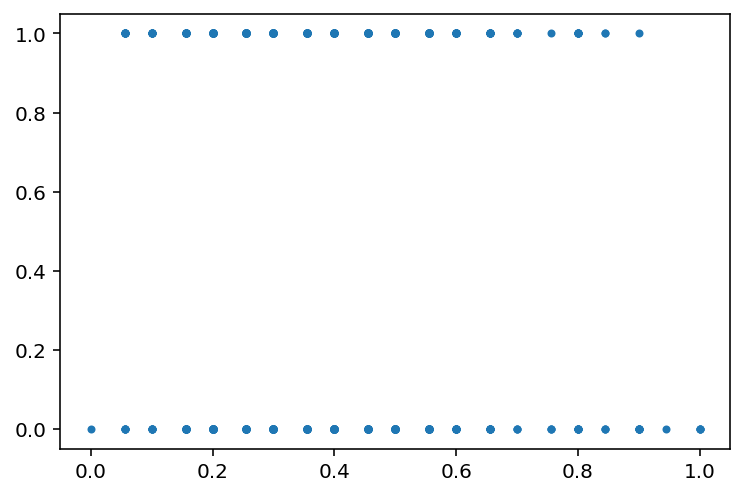

In [ ]:
plot(data_normalized['wind'],data_normalized['area'],'.')

In [ ]:
n_samples = 100  # 100 lines

beta0s = stats.norm.rvs(0.5, 0.2,n_samples)
betas_temp = stats.norm.rvs(0.1, 0.2, n_samples)
betas_RH = stats.norm.rvs(-0.2, 0.2, n_samples)
betas_wind = stats.norm.rvs(0.2, 0.2, n_samples)
betas_rain = stats.norm.rvs(-0.1, 0.2, n_samples)


tempmin = data_normalized['temp'].min() 
tempmax = data_normalized['temp'].max()
temps = linspace(tempmin, tempmax, 5) ## temps range

RHmin = data_normalized['RH'].min()
RHmax = data_normalized['RH'].max()
RHs = linspace(RHmin, RHmax, 5) ## RHs range

windmin = data_normalized['wind'].min()
windmax = data_normalized['wind'].max()
winds = linspace(windmin, windmax, 5) ## winds range

rainmin = data_normalized['rain'].min()
rainmax = data_normalized['rain'].max()
rains = linspace(rainmin, rainmax, 5) ## rains range
smallest = min(RHmin,tempmin,windmin)
smallest


0.0

In [ ]:
data_normalized['rain'].std()

0.04624361263920219

Text(0, 0.5, 'area')

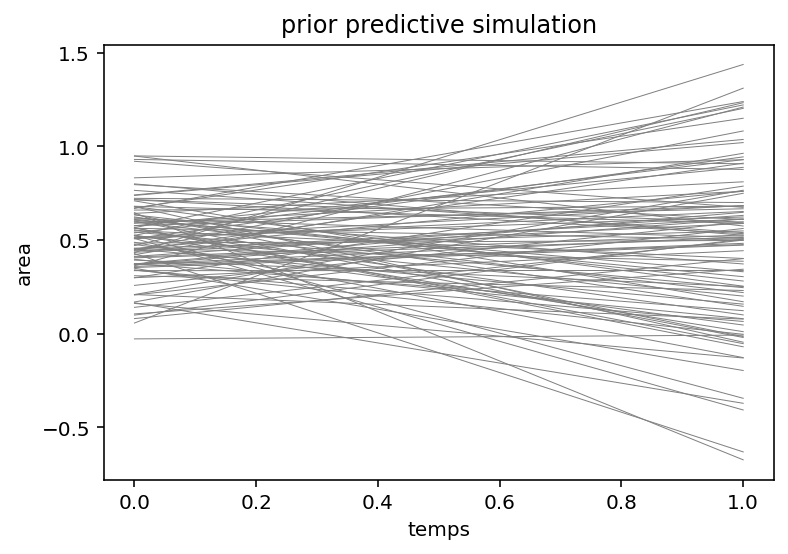

In [ ]:
## we are using broadcasting here (see Notebook in Week 4)
area_avg = beta0s[None, :] + betas_temp[None, :]*temps[:, None] + betas_RH[None, :]*RHs[:, None] + betas_wind[None, :]*winds[:, None] + betas_rain[None, :]*rains[:, None] 

plot(RHs, area_avg, '0.5', lw=0.5)
title('prior predictive simulation')
xlabel('temps')
ylabel('area')

Text(0, 0.5, 'area')

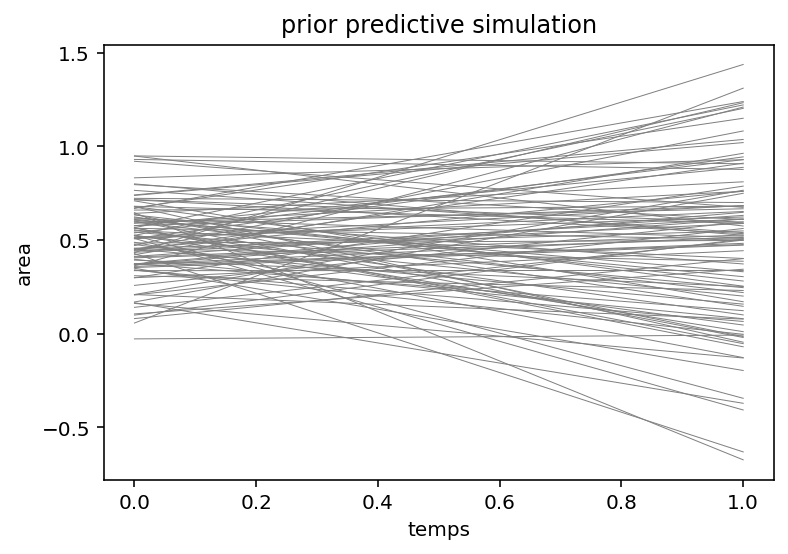

In [ ]:
## we are using broadcasting here (see Notebook in Week 4)
area_avg = beta0s[None, :] + betas_temp[None, :]*temps[:, None] + betas_RH[None, :]*RHs[:, None] + betas_wind[None, :]*winds[:, None] + betas_rain[None, :]*rains[:, None] 

plot(temps, area_avg, '0.5', lw=0.5)
title('prior predictive simulation')
xlabel('temps')
ylabel('area')

In [ ]:
with pm.Model() as model_1:
    beta0 = pm.Beta('beta0', alpha=2,beta=2)
    beta_temp = pm.Normal('beta_temp', mu=0.4, sd=0.2)
    beta_RH = pm.Normal('beta_RH', mu=-0.5, sd=0.2)
    beta_wind = pm.Normal('beta_wind', mu=0.3, sd=0.2)
    beta_rain = pm.Normal('beta_rain', mu=-0.2, sd=0.2)
    sigma = pm.Exponential('sigma',lam=2)

    _mu = beta0 + beta_temp*data_normalized['temp'] + beta_RH*data_normalized['RH'] + beta_wind*data_normalized['wind']+  beta_rain*data_normalized['rain']  
    mu = pm.Beta('mu',mu= _mu[0],sigma=sigma) 
    
    A = pm.Bernoulli('areas',p=mu,observed =data_normalized['area'])
    ## MCMC
    _Area_posterior = pm.sample(1000, tune=1000, cores=4)
    print(pm.summary(_Area_posterior, var_names=['beta0','beta_temp', 'beta_RH', 'beta_wind', 'beta_rain','sigma']))
Area_posterior = pm.trace_to_dataframe(_Area_posterior)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, beta_rain, beta_wind, beta_RH, beta_temp, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
There were 317 divergences after tuning. Increase `target_accept` or reparameterize.
There were 453 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6121962421945425, but should be close to 0.8. Try to increase the number of tuning steps.
There were 500 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5640458271652762, but should be close to 0.8. Try to increase the number of tuning steps.
There were 327 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7071773279179022, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sa

            mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
beta0      0.452  0.168   0.129    0.741  ...    0.012     109.0     963.0   1.03
beta_temp  0.395  0.198   0.026    0.777  ...    0.008     309.0     211.0   1.02
beta_RH   -0.532  0.204  -0.938   -0.177  ...    0.021      61.0      30.0   1.05
beta_wind  0.274  0.178  -0.038    0.619  ...    0.008     310.0    1272.0   1.02
beta_rain -0.205  0.199  -0.578    0.168  ...    0.007     417.0     659.0   1.01
sigma      0.138  0.097   0.017    0.323  ...    0.006      67.0     121.0   1.06

[6 rows x 9 columns]


In [ ]:
with pm.Model() as model_2:
    beta0 = pm.Beta('beta0', alpha=2,beta=2)
    beta_temp = pm.Normal('beta_temp', mu=0.4, sd=0.2)
    beta_RH = pm.Normal('beta_RH', mu=-0.5, sd=0.2)
    beta_wind = pm.Normal('beta_wind', mu=0.3, sd=0.2)
    beta_rain = pm.Normal('beta_rain', mu=-0.2, sd=0.2)
    sigma = pm.Exponential('sigma',lam=2)

    _mu = beta0 + beta_temp*data_normalized['temp'] + beta_RH*data_normalized['RH'] + beta_wind*data_normalized['wind']+  beta_rain*data_normalized['rain']  
    mu = pm.Beta('mu',mu= _mu[1],sigma=sigma) 
    
    A = pm.Bernoulli('areas',p=mu,observed =data_normalized['area'])
    ## MCMC pm.sample(..., nuts_kwargs=dict(target_accept=0.95))
    _Area_posterior2 = pm.sample(100, tune=6000, cores=4)
    print(pm.summary(_Area_posterior2, var_names=['beta0','beta_temp', 'beta_RH', 'beta_wind', 'beta_rain']))
Area_posterior2 = pm.trace_to_dataframe(_Area_posterior)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, beta_rain, beta_wind, beta_RH, beta_temp, beta0]


Sampling 4 chains for 6_000 tune and 100 draw iterations (24_000 + 400 draws total) took 37 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


            mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
beta0      0.411  0.158   0.154    0.717  ...    0.012     149.0      79.0   1.04
beta_temp  0.380  0.193   0.025    0.709  ...    0.009     225.0     267.0   1.02
beta_RH   -0.505  0.201  -0.884   -0.140  ...    0.010     219.0     194.0   1.03
beta_wind  0.298  0.214  -0.085    0.694  ...    0.010     278.0     196.0   1.00
beta_rain -0.152  0.196  -0.553    0.212  ...    0.009     231.0     170.0   1.01

[5 rows x 9 columns]


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f75ab0b3b50>,
      dtype=object)

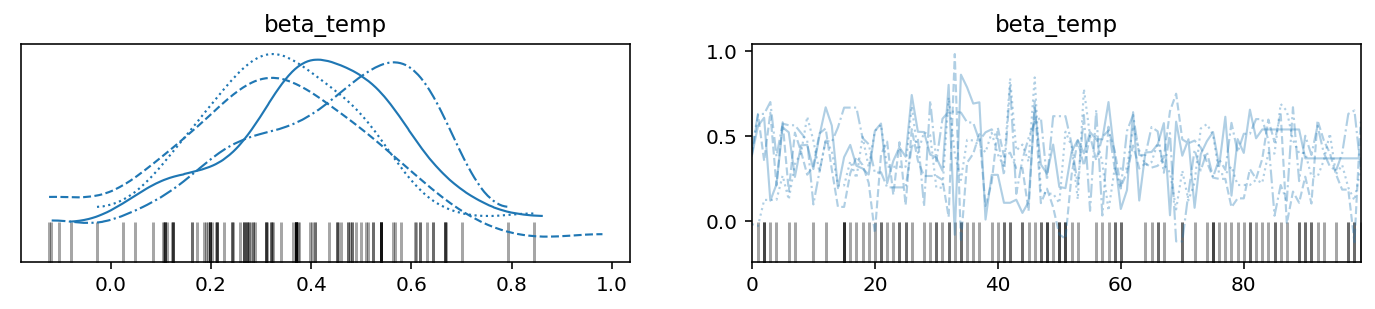

In [ ]:
az.plot_trace(_Area_posterior2,['beta_temp'])

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f75a89a2310>,
      dtype=object)

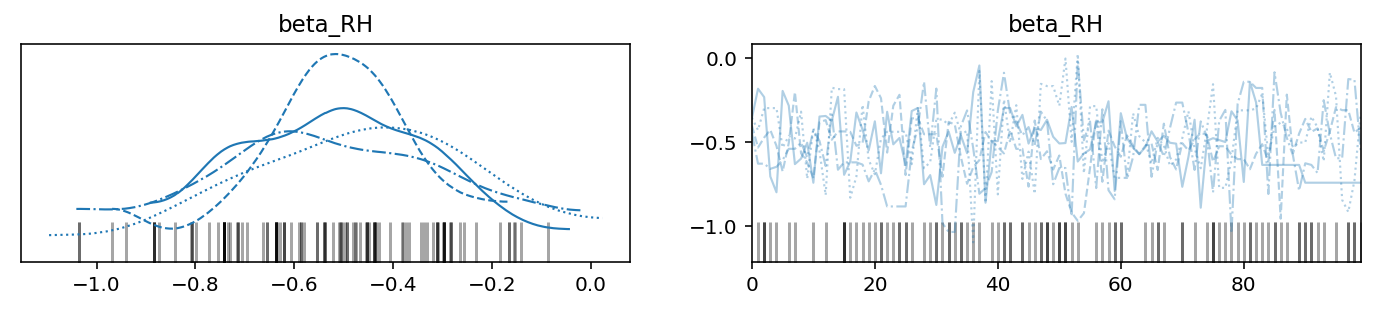

In [ ]:
az.plot_trace(_Area_posterior2,['beta_RH'])

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f75a9b96c50>,
      dtype=object)

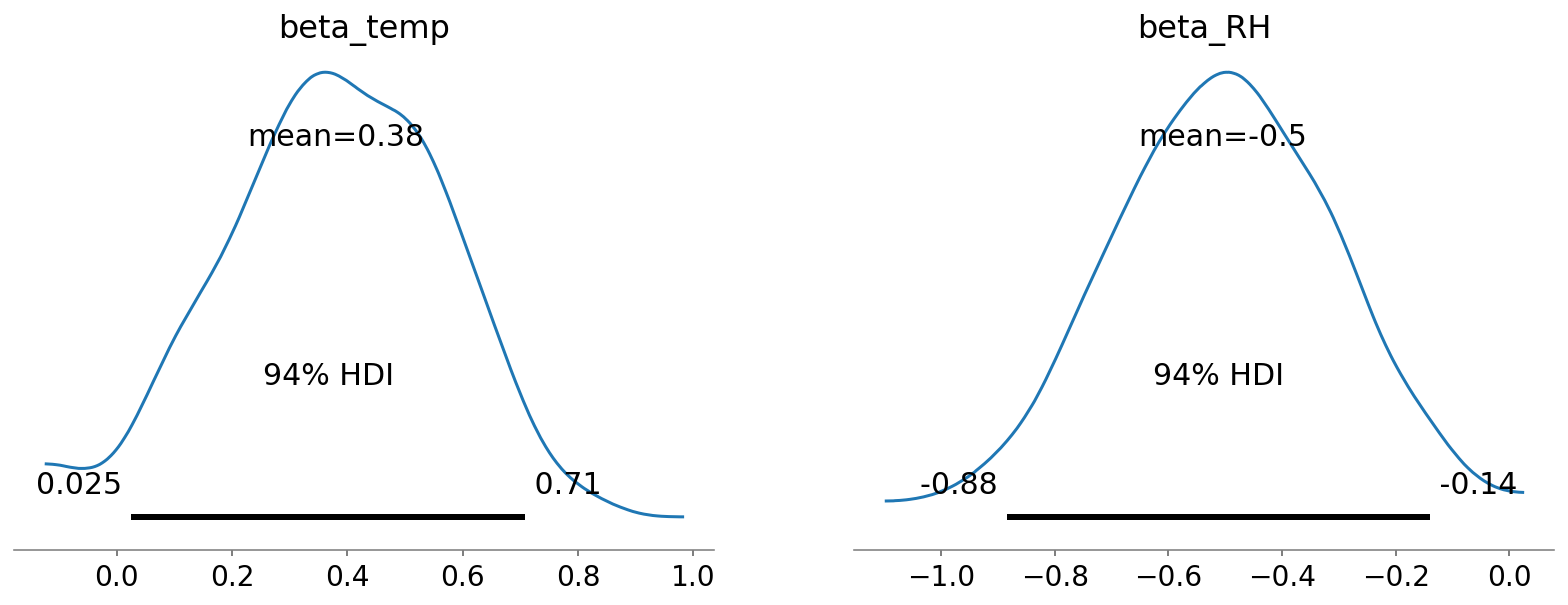

In [ ]:
pm.plot_posterior(_Area_posterior2,var_names=['beta_temp', 'beta_RH'])

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f75ba1c3410>,
      dtype=object)

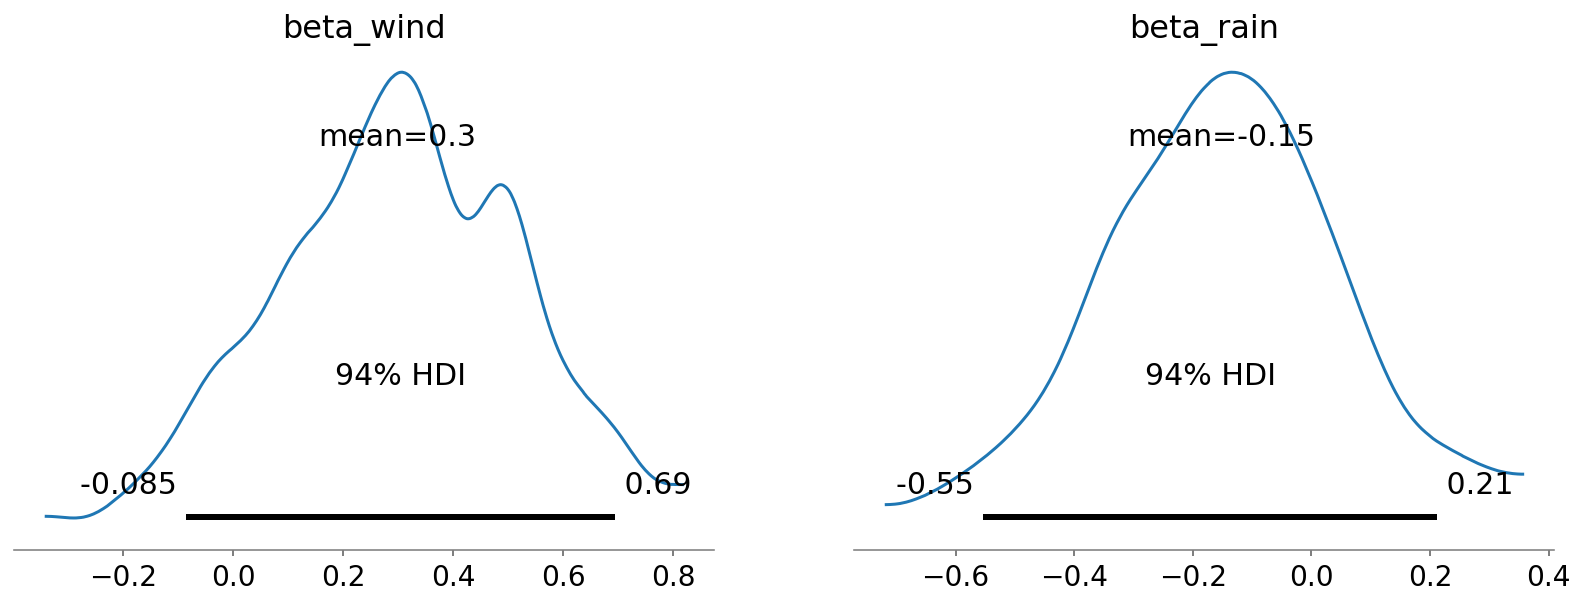

In [ ]:
pm.plot_posterior(_Area_posterior2,var_names=['beta_wind', 'beta_rain'])

## **Prediction**

In [ ]:
with model_2:
    ppc = pm.sample_posterior_predictive(
        
        _Area_posterior2, var_names=['beta0','beta_temp', 'beta_RH', 'beta_wind', 'beta_rain','areas','sigma']
    )

In [ ]:
data_order= data_normalized.sort_values('temp')
data_order

,temp,RH,wind,rain,area
280,0.000000,0.517647,0.500000,0.0,0
282,0.064309,0.423529,0.400000,0.0,1
279,0.077170,0.070588,0.900000,0.0,0
278,0.077170,0.070588,0.900000,0.0,0
277,0.077170,0.070588,0.900000,0.0,0
...,...,...,...,...,...
491,0.971061,0.070588,0.455556,0.0,1
492,0.971061,0.141176,0.200000,0.0,1
496,0.977492,0.129412,0.300000,0.0,0
484,0.993569,0.117647,0.400000,0.0,0


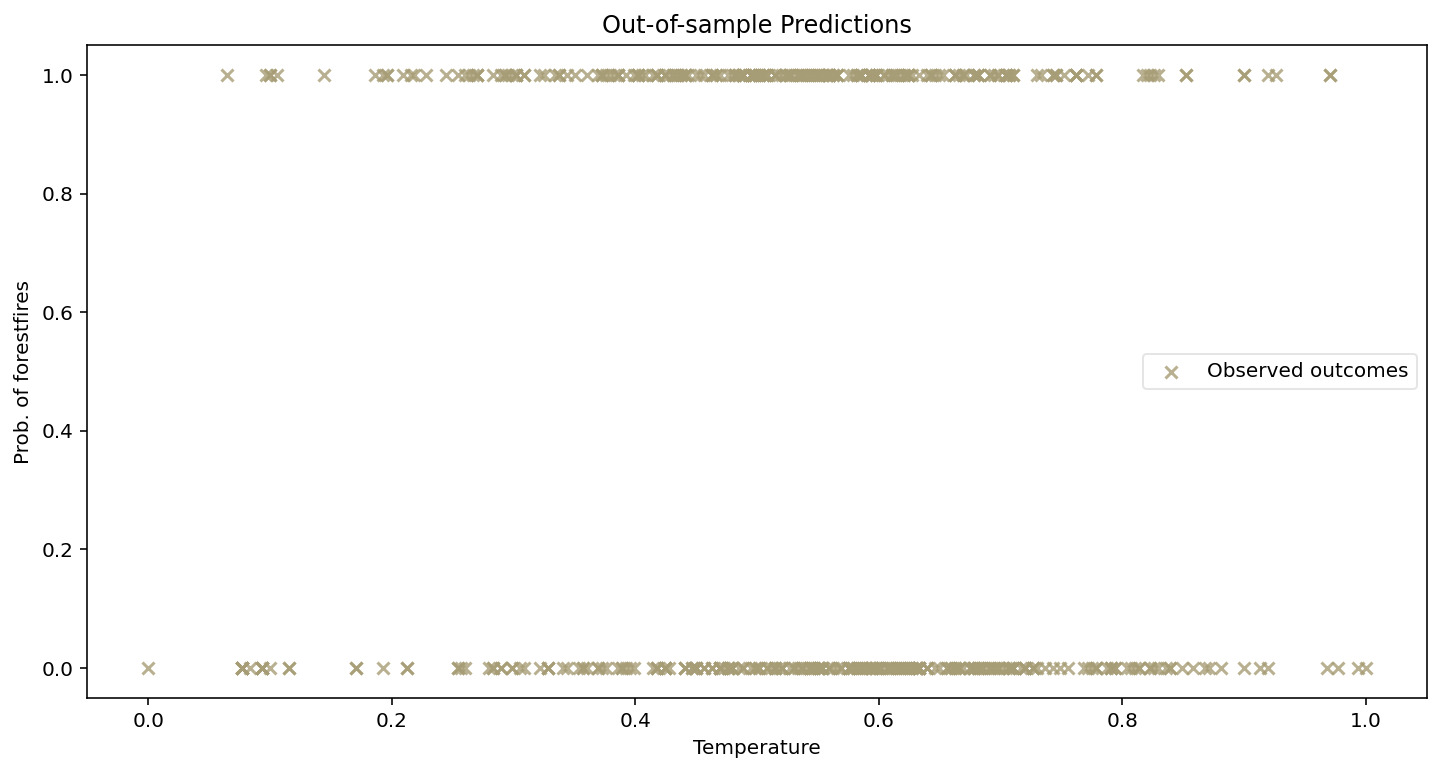

In [ ]:
predictors_out_of_sample = array(data_order['temp'])
outcomes_out_of_sample = array(data_order['area'])

_, ax = plt.subplots(figsize=(12, 6))
model_preds = ppc["areas"]


ax.scatter(
    x=predictors_out_of_sample,
    y=outcomes_out_of_sample,
    marker="x",
    color="#A69C75",
    alpha=0.8,
    label="Observed outcomes",
)
ax.set_xlabel("Temperature")
ax.set_ylabel("Prob. of forestfires")
ax.set_title("Out-of-sample Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5);


In [ ]:
y_score = np.mean(ppc['areas'], axis=0)
roc_auc_score(y_score=np.mean(ppc['areas'], axis=0), 
              y_true=data_normalized['area'])

0.4997975708502024

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f75a97d6c10>,
      dtype=object)

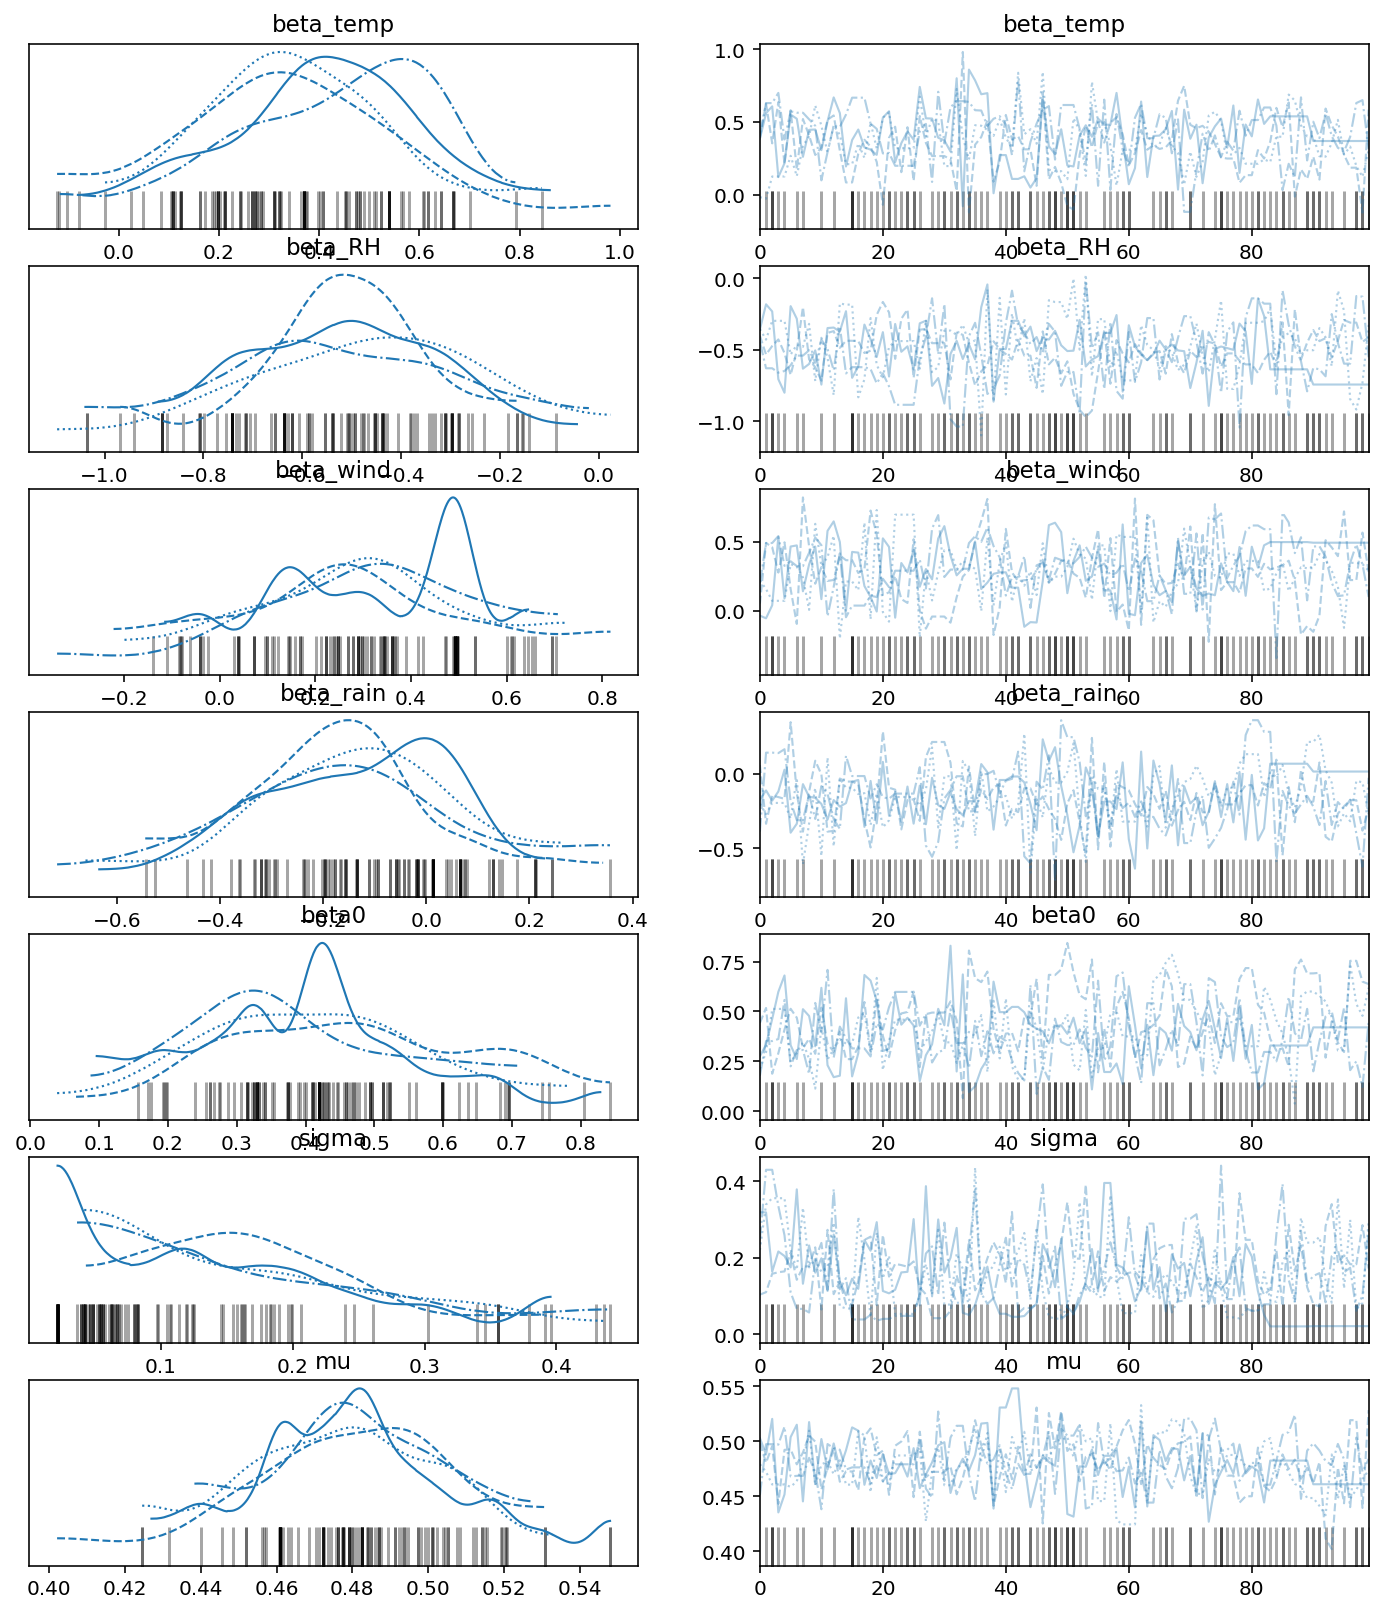

In [ ]:
pm.plot_trace(_Area_posterior2)

## Random forest

In [ ]:
y = np.array(data_normalized['area'])
X = data_normalized.drop('area',axis=1)
X_list =list(X.columns)
X = np.array(X)

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5512820512820513
